In [ ]:
# This notebook applies normalizing flows to the `purple-forest.csv.gz` color dataset.

# See `purple-forest.jpg` for a rendering of colors from the dataset, and `purple-forest-epoch-*.jpg` for example output that I've converted back to JPG.

In [1]:
import torch
import torch.nn as nn
import torch.autograd as grad
from torch.distributions import MultivariateNormal

import math
from flows import *

import pandas
import torch.utils.data

table = torch.tensor(pandas.read_csv("../datasets/purple-forest.csv.gz").values, dtype=torch.float32)
print(table)
dataset = torch.utils.data.TensorDataset(table)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000)

tensor([[ 0.0343, -0.0735,  0.6441],
        [-0.5966, -0.6806,  0.4833],
        [-0.1722, -0.4614,  0.8236],
        ...,
        [-0.3445, -0.3445,  0.6930],
        [-1.3788, -1.6563,  0.2523],
        [-0.7567, -0.9091,  0.4943]])


In [21]:
# Define a 3-dimensional flow with many Triangular matrix multiplies, intermediate quadratic non-linearities, and a logarithmic non-linearity
# normal_flows converts the source distribution into the Normal distribution with identity covariance
dim = 3
normal_flows = Flows(
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    SoftsquareFlow(3),
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    SoftsquareFlow(3),
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    SoftlogFlow(),
)

net = FlowModule(normal_flows, NegLogLikelihoodLoss(dim))
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

print(list(net.parameters()))

[Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([1., 1., 1.], requires_grad=True), Parameter containing:
tensor([1.0000e-16, 1.0000e-16, 1.0000e-16], requires_grad=True), Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True), Parameter containing:
tensor([0., 0., 0.]

In [22]:
# The training loop!  With some additional debugging code if NaNs are detected in the loss function.
# This can happen due to the use of Sigmoid - where extreme values can saturate the gradients.
final_loss = 0.0
nan_data = torch.tensor([])
for batch in range(60):  #1oop over the dataset multiple times
    for _, data in enumerate(dataloader, 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = net(data[0])
        if loss != loss:
            nan_data = data
            print("Nan found during training.  Aborting")
            break
        
        loss.backward()
        optimizer.step()
        final_loss = loss
print("final loss: %.03f" % final_loss)

final loss: 1.352


In [9]:
# Print the trained network parameters
for f in normal_flows.flows:
    print(f)
    for name, param in f.named_parameters():
        print("  %s = %s" % (name, param.data))
    print()

DenseTriangularFlow()
  w = tensor([[ 1.3338, -0.2512, -0.0063],
        [ 0.0000,  1.1875, -0.1328],
        [ 0.0000,  0.0000,  0.8984]])
  b = tensor([ 0.0396,  0.1789, -0.4184])

DenseTriangularFlow()
  w = tensor([[ 1.2293,  0.0000,  0.0000],
        [-0.4795,  1.1653,  0.0000],
        [ 0.1799, -0.0567,  0.9607]])
  b = tensor([-0.0016,  0.1861, -0.4128])

DenseTriangularFlow()
  w = tensor([[ 1.2102, -0.2621,  0.2677],
        [ 0.0000,  1.2581, -0.0815],
        [ 0.0000,  0.0000,  0.9758]])
  b = tensor([-0.0016,  0.1759, -0.4442])

DenseTriangularFlow()
  w = tensor([[ 1.1059,  0.0000,  0.0000],
        [-0.4064,  1.1876,  0.0000],
        [ 0.2510, -0.4513,  1.0738]])
  b = tensor([-0.0871,  0.1796, -0.4502])

SoftsquareFlow()
  a = tensor([1.3599, 1.3435, 0.9203])
  b = tensor([-0.0059,  0.0821,  0.5579])

DenseTriangularFlow()
  w = tensor([[ 1.2208, -0.2617, -0.4883],
        [ 0.0000,  1.3158,  0.2107],
        [ 0.0000,  0.0000,  1.0194]])
  b = tensor([-0.2587, -0.053

In [25]:
# Run the network in reverse to generate data, and export it to a CSV.
import pandas

outputs = MultivariateNormal(torch.zeros(dim), torch.eye(dim)).sample_n(1000)
inputs, log_det = normal_flows.backward(outputs)
pandas.DataFrame(inputs.detach().numpy()).to_csv('../datasets/purple-forest-output.csv', header=False, index=False)

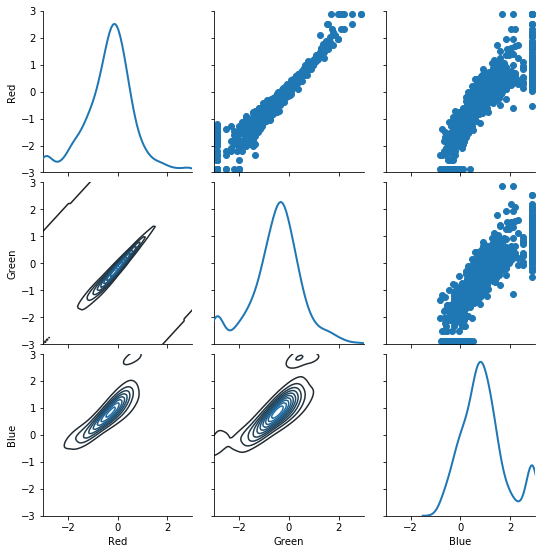

In [137]:
# Use Seaborn to generate X-Y plots on each pair of variables (from the source data)
import numpy
import seaborn
import matplotlib.pylab
import pandas
cols = ['Red', 'Green', 'Blue']
data = pandas.DataFrame(table[0:1000].numpy(), columns = cols)
g = seaborn.PairGrid(data)
g.map_upper(matplotlib.pylab.scatter)
g.map_diag(seaborn.kdeplot, lw=2, legend=False);
g.map_lower(seaborn.kdeplot)

g.set(xlim=(-3, 3), ylim=(-3, 3))

matplotlib.pylab.show()

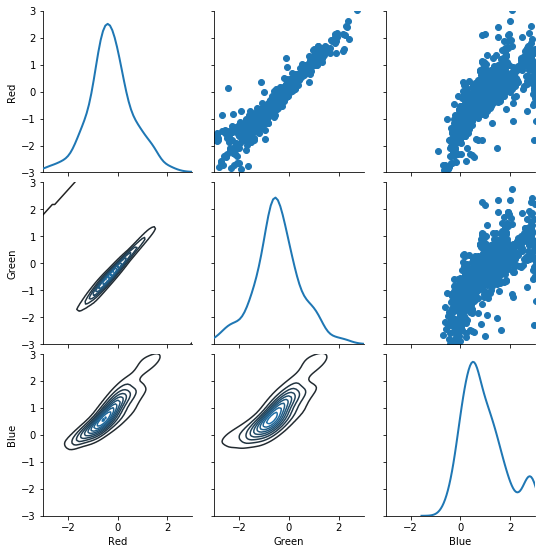

In [24]:
# Similar plots on generated data (from the trained model)
import numpy
import seaborn
import matplotlib.pylab
import pandas
cols = ['Red', 'Green', 'Blue']
data = pandas.DataFrame(inputs[0:1000].detach().numpy(), columns = cols)
g = seaborn.PairGrid(data)
g.map_upper(matplotlib.pylab.scatter)
g.map_diag(seaborn.kdeplot, lw=2, legend=False);
g.map_lower(seaborn.kdeplot)

g.set(xlim=(-3, 3), ylim=(-3, 3))

matplotlib.pylab.show()